# Invoices Attribute Extraction

<pre>
We are given with a problem of automating the extraction of attributes such as Invoice Number, issuer, date, etc. from the given invoices. 

Now, invoices dont follow a structure as such, different companies have different structures for it. Some have handwritten invoices, some have machine printed, while some are more like receipts. To add to it, some may write invoice number to the left at the top, some in middle or right, or something like that. Thus, we have to come up with a way to generalize the solution for all sorts of invoices.

For the given dataset, upon going through them, one thing I noticed was that the PDFs actually contained lots of pages, all of which were not invoices. That is, some pages were related to Bill of Landing, some certificates of origins, etc.

So, for approaching the problem, we will break it up into multiple subproblems, each of which will be discussed in detail.
</pre>

## 1. Invoices Classification

<pre>
As discussed above, we have noticed that not all of the pages of PDFs are invoices, so we would have to first extract those pages which are invoices, and disregard those for the current problem.

This can be done in two ways:

1) Using Computer Vision
2) Using NLP techniques

Firstly, we have hand labelled the pages which are invoices, and those which are not.
We have a set of around 100 images (14 PDFs) of which about 20% are invoices, and rest are non-invoices. 


For first solution, what we do is that we extract the bottleneck features of images from the pretrained VGG 16 network (imagenet weights). After getting those bottleneck features, we send those features through a simple LogisticRegression Clasifier. We are using F1-Score to measure the performance of classifier, because we are focussing on how well does our model perform on positive class label (i.e. Invoices).
The F1-Score obtained is not great in as such, i.e. it is just 0.54. However, the caveat here is that:

Although the performance might not be too good, but we know that Images contain lots of information, more than the raw text itself, and over the years we have seen ConvNets performing brilliantly in all Computer Vision domains. Due to the contraint of the amount/number of images here, we had to take the bottleneck features from the network, which was trained on Imagenet images. While if we were to actually train and refine this network on our images (i.e. on identifying invoices), and instead of using bottlenecks, if we could use the network itself for classification, the performance would increase dramatically.

For the second solution, the approach was:
As we know that usually the titles and top part of an invoice define what kind of a page it is, so we extracted the top 9 lines from the pdfs, and used that text data to find if it was an invoice or not. 
For the classification part, we could not use Neural Networks here, because of limited amount text here. Instead, we stuck with core ML featurizations. For featurizations, we used the number of occurrences of each entity types, along with some Flags (such as occurrence of word 'invoice') and we also used n-gram Bag of words. Although the text gave lot better results compared to images (F1-Score of 0.8), it is not fair to say which one would outperform the other given good amount of data.

## Importing Libraries

In [4]:
!python -m spacy download en

In [40]:
import pytesseract
import cv2
import numpy as np
import pandas as pd
import re
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
from pprint import pprint
import os
import shutil
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import sklearn
from pdf2image import convert_from_path, convert_from_bytes
from PIL import Image 
from google.colab.patches import cv2_imshow
from pytesseract import Output
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [6]:
#extracting invoices
!tar xf invoices.tar.gz

## Preprocessing of Data

In [7]:
#getting the invoice paths
invoices_paths = [r'invoices/' + ele for ele in os.listdir('invoices')]

In [12]:
def convert_pdf_to_img(pdf_paths):
    '''
    Function to convert the pdfs to images
    '''
    #creating a folder for images
    if not os.path.exists('invoices_images'):
        os.mkdir('invoices_images')
    
    for inv in pdf_paths:
        #if the file is a pdf, convert it, if not, simply move it to new directory
        if '.pdf' in inv.lower():
            # Store Pdf with convert_from_path function 
            images = convert_from_bytes(open(inv, 'rb').read())
            img_name_prefix = inv.split('/')[-1].replace('.pdf', '')
            os.mkdir('invoices_images/' + img_name_prefix)
            for index, img in enumerate(images): 
                #saving each image
                img.save('invoices_images/' + img_name_prefix + '/' + img_name_prefix + '_' + str(index) + '.jpg', 'JPEG')
        else:
            img_name_prefix = inv.split('/')[-1].replace('.jpg','')
            os.mkdir('invoices_images/' + img_name_prefix)
            shutil.copy(inv, 'invoices_images/' + img_name_prefix)
            os.chdir('invoices_images/' + img_name_prefix)
            #renaming the image
            os.rename(img_name_prefix + '.jpg', img_name_prefix + '_0.jpg')
            os.chdir('/home/jupyter')
            
convert_pdf_to_img(invoices_paths)

In [13]:
#manually labelling the images
labels_dict = {'201611150851' : [0,1,0],
               '433667' : [0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,1,0],
               '52.831_OR' : [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               '5712_-_N.R_Agarwal_-_INOVICE_79.320' : [1,0,0,0,0,0,0,0,0,0],
               'a-000' : [1],
               'CI-D' : [1],
               'DEEP_PLAST_20.700' : [1,0,0,0,0,0,0],
               'DEEP_PLAST_49.896' : [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               'DOC_LOT_94.860_MT.PDF' : [0,1,0,0,0,0,0],
               'FORD_India_62937_Inv_PL.PDF' : [1,1,1,0,0,0,0,0],
               'INVOICE__SURAJ_210' : [1],
               'N_R_Agarwal_DPD_Unit_5-957395634_74.524' : [1,0,0,0,0,0,0,0,0,0,0,0],
               'S_PSO-E96_16072121220' : [1,0,0,0,0],
               'S_PSO-E96_16072919550' : [1,0,0]}

#creating a df of images and labels
invoices_img_paths = ['invoices_images/' + ele for ele in os.listdir('invoices_images')]

df = pd.DataFrame(columns = ['path','label'])
for path in invoices_img_paths:
    #getting list of each pdf's images
    images = os.listdir(path)
    folder_name = path.split('/')[-1]
    #getting path names for each image
    img_paths = [path + '/' + ele for ele in images]
    #sorting the paths (as os.listdir gives shuffled paths)
    argsorts = np.argsort([int(ele.split('_')[-1].split('.')[0]) for ele in img_paths])
    img_paths = np.array(img_paths)[argsorts]
    #appending the row to df
    df = df.append(pd.DataFrame({'path' : img_paths, 'label' : labels_dict.get(folder_name)}))

In [14]:
#checking the df
display(df.head())
print(f"Shape of dataframe : {df.shape}")
print("\nDistribution of labels:")
print(f"{df.label.value_counts()}")

#shuffling the DataFrame
df = df.sample(frac = 1)
df = df.reset_index(drop = True)

,path,label
0,invoices_images/S_PSO-E96_16072121220/S_PSO-E9...,1
1,invoices_images/S_PSO-E96_16072121220/S_PSO-E9...,0
2,invoices_images/S_PSO-E96_16072121220/S_PSO-E9...,0
3,invoices_images/S_PSO-E96_16072121220/S_PSO-E9...,0
4,invoices_images/S_PSO-E96_16072121220/S_PSO-E9...,0


Shape of dataframe : (112, 2)

Distribution of labels:
0    89
1    23
Name: label, dtype: int64


## Checking for orientation of images

In [16]:
# checking for rotated images
total_rotated = 0
for image_path in df.path:
    #reading the image
    img = cv2.imread(image_path)
    #getting orientation detail from tesseract
    orientation_details = pytesseract.image_to_osd(img)
    rotation_angle = int(re.search(r'Rotate: (\d+)', orientation_details).group(1))
    
    if rotation_angle == 0:
        continue
    elif rotation_angle == 90:
        rot = cv2.ROTATE_90_CLOCKWISE
    elif rotation_angle == 270:
        rot = cv2.ROTATE_90_COUNTERCLOCKWISE
    elif rotation_angle == 180:
        rot = cv2.ROTATE_180
    
    #rotating the image by required angle
    img = cv2.rotate(img, rot)
    cv2.imwrite(image_path, img)
    total_rotated += 1
        
print("Total Images Rotated =", total_rotated)

Total Images Rotated = 8


## Image Classification

### Using Computer Vision

In [17]:
#loading the images in memory
def load_images(df):
    #we will keep them to (224,224,3) shape for VGG16 compatibility
    imgs_arrays = np.zeros((len(df), 224, 224, 3))
    
    for i, image_path in enumerate(df.path):
        img = cv2.imread(image_path)
        #switching the channels
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #doing preprocessing for vgg16
        img_rgb = cv2.resize(img_rgb, (224,224), cv2.INTER_NEAREST)
        #rescaling the image
        img_rgb = img_rgb/255.0
        img_rgb = np.expand_dims(img_rgb, 0)
        imgs_arrays[i] = img_rgb
        
    return imgs_arrays

imgs_arrays = load_images(df)

In [18]:
#we will extract bottleneck features for all these images from a VGG-16 pretrained network
vgg = tf.keras.applications.VGG16(include_top=False,
                                   weights='imagenet',
                                   input_shape=(224,224,3))
#adding a flattening layer for the output of convolved image
flattening_layer = tf.keras.layers.Flatten()(vgg.output)
#defining the model
model = tf.keras.models.Model(inputs = vgg.input, outputs = flattening_layer)

58892288/58889256 [==============================] - 0s 0us/step


In [19]:
#getting the bottleneck features
imgs_bottlenecks = model.predict(imgs_arrays)
print(f"Shape of Image Bottleneck Features = {imgs_bottlenecks.shape}")

Shape of Image Bottleneck Features = (112, 25088)


In [20]:
#using a simple LogisticRegressionClassifier for doing classifying the images as invoice and non-invoice using Stratified K-fold
def fit_lr_cv(param, X, Y, return_preds = False, return_lr_coef = False):
    
    print(f"Fitting LR on C = {param}")
    #defining the model
    lr = LogisticRegression(C = param, 
                            n_jobs = -1, 
                            class_weight = 'balanced')
    
    cv = StratifiedKFold(n_splits = 3)
    #using out of fold predictions, as the data is too small for splitting the dataset
    cv_preds = np.zeros(len(X))
    
    for train_ind, cv_ind in cv.split(X, Y):
        x_tr = X[train_ind]
        x_cv = X[cv_ind]
        y_tr = Y[train_ind]
        y_cv = Y[cv_ind]
        #fitting the model
        lr.fit(x_tr, y_tr)
        #oof preds
        cv_preds[cv_ind] = lr.predict(x_cv)
        
    print(f"Done.\nCV F1 Score = {sklearn.metrics.f1_score(Y, cv_preds)}")
    
    if return_preds:
        if return_lr_coef:
            return cv_preds, lr.coef_[0]
        return cv_preds

In [21]:
#defining the param grid
param_c = [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
#fitting on each parameter
for param in param_c:
    fit_lr_cv(param, imgs_bottlenecks, df.label.values.astype('int'))

Fitting LR on C = 1e-06
Done.
CV F1 Score = 0.4
Fitting LR on C = 1e-05
Done.
CV F1 Score = 0.5333333333333333
Fitting LR on C = 0.0001
Done.
CV F1 Score = 0.5333333333333333
Fitting LR on C = 0.001
Done.
CV F1 Score = 0.5283018867924527
Fitting LR on C = 0.01
Done.
CV F1 Score = 0.5
Fitting LR on C = 0.1
Done.
CV F1 Score = 0.5238095238095238
Fitting LR on C = 1
Done.
CV F1 Score = 0.5365853658536586
Fitting LR on C = 10
Done.
CV F1 Score = 0.5238095238095238
Fitting LR on C = 100
Done.
CV F1 Score = 0.5365853658536586


Best C obtained was 1, so fitting the model on 1 param and checking the metrics.

In [22]:
#using a simple LogisticRegressionClassifier for doing classifying the images as invoice and non-invoice
cv_preds_img = fit_lr_cv(1, imgs_bottlenecks,
                         df.label.values.astype('int'), 
                         return_preds = True)

print(f"Classification Report:\n{sklearn.metrics.classification_report(df.label.values.astype('int'), cv_preds_img)}")

Fitting LR on C = 1
Done.
CV F1 Score = 0.5365853658536586
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90        89
           1       0.61      0.48      0.54        23

    accuracy                           0.83       112
   macro avg       0.74      0.70      0.72       112
weighted avg       0.82      0.83      0.82       112



### Using NLP Techniques

In [23]:
#extracting the text first from the images
def extract_text_ocr(df):
    texts = []
    for image_path in df.path:
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #reading text using tesseract
        text = pytesseract.image_to_string(img_rgb)
        texts.append(text)
        
    return texts

texts = extract_text_ocr(df)

In [24]:
#preprocessing the texts a little bit:
imp_texts = []
for text in texts:
    text = text.split('\n')
    #taking only those words which have a length > 1
    text = [ele for ele in text if len(ele)>1]
    #taking the first 9 rows as they contain info if it is invoice or something else
    text = text[:9]
    text = ' '.join(text)
    imp_texts.append(text)

In [26]:
#getting the NERs from the text and using the number of those as features

entities = ['PERSON', 'NORP','FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT',
            'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE', 'DATE', 'TIME',
            'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL', 'FLAG_INVOICE', 'FLAG_DATE', 'NUMERICS']
#dataframe for Classification
df_feats = pd.DataFrame(columns = entities)

nlp = en_core_web_sm.load()

for text in imp_texts:
    doc = nlp(text)
    #getting the NER labels
    labels = [X.label_ for X in doc.ents]
    #counting occurrence of each label
    label_occurrences = { k: [v] for k,v in Counter(labels).items()}
    
    #creating flag features
    label_occurrences['FLAG_INVOICE'] = [1] if 'invoice' in text.lower() else [0]
    label_occurrences['FLAG_DATE'] = [1] if 'date' in text.lower() else [0]
    #appending the row to dataframe
    df_feats = df_feats.append(pd.DataFrame(label_occurrences))

#filling missing values with 0, as they have 0 occurrences
df_feats = df_feats.fillna(0)

In [28]:
def preprocess_texts(imp_texts):
    final_texts = []
    for index, text in enumerate(imp_texts):
        text = imp_texts[index]
        #removing all the special characters
        text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
        #removing any extra outside white characters
        text = text.strip()
        #lowering the case of text
        text = text.lower()
        #removing any extra inner whitespace characters
        text = ' '.join(text.split())
        final_texts.append(text)
        
    return final_texts


preprocessed_text = preprocess_texts(imp_texts)

#vectorizing them using BOW
#creating n-grams from text, and keeping only top 500 n-grams
count = CountVectorizer(max_features = 500, ngram_range = (1,3))
preprocessed_text = count.fit_transform(np.array(preprocessed_text))

#appending these features to above DataFrame
bow_df = pd.DataFrame(preprocessed_text.toarray(), columns = count.get_feature_names())
df_feats = pd.concat([df_feats, bow_df.set_index(df_feats.index)], axis = 1)
#checking the final DataFrame
df_feats.head(10)

,PERSON,NORP,FAC,ORG,GPE,LOC,PRODUCT,EVENT,WORK_OF_ART,LAW,...,whether,which,with,wm,wm recycle,wm recycle america,wuhan,wuhan avenue,wuhan avenue changchun,www
0,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,2,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
0,3,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#using a simple LogisticRegressionClassifier for doing classifying the images as invoice and non-invoice
param_c = [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for param in param_c:
    fit_lr_cv(param, df_feats.values, df.label.values.astype('int'))

Fitting LR on C = 1e-06
Done.
CV F1 Score = 0.49411764705882344
Fitting LR on C = 1e-05
Done.
CV F1 Score = 0.5333333333333333
Fitting LR on C = 0.0001
Done.
CV F1 Score = 0.6181818181818182
Fitting LR on C = 0.001
Done.
CV F1 Score = 0.6274509803921569
Fitting LR on C = 0.01
Done.
CV F1 Score = 0.6666666666666666
Fitting LR on C = 0.1
Done.
CV F1 Score = 0.7083333333333334
Fitting LR on C = 1
Done.
CV F1 Score = 0.7499999999999999
Fitting LR on C = 10
Done.
CV F1 Score = 0.782608695652174
Fitting LR on C = 100
Done.
CV F1 Score = 0.7555555555555555


Using the best hyperparameter obtained to train the model.

In [31]:
#using a simple LogisticRegressionClassifier for doing classifying the images as invoice and non-invoice
cv_preds, lr_coef = fit_lr_cv(10, df_feats.values,
                       df.label.values.astype('int'), 
                       return_preds = True, return_lr_coef = True)
  
print(f"Classification Report:\n{sklearn.metrics.classification_report(df.label.values.astype('int'), cv_preds)}")

Fitting LR on C = 10
Done.
CV F1 Score = 0.782608695652174
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        89
           1       0.78      0.78      0.78        23

    accuracy                           0.91       112
   macro avg       0.86      0.86      0.86       112
weighted avg       0.91      0.91      0.91       112



In [32]:
#checking the top 20 important features

#top coefficients are
coefs_best = np.argsort(np.abs(lr_coef))[::-1]
top_50_feats = coefs_best[:50]

print("Top columns for classification task are:")
df_feats.columns[top_50_feats]

Top columns for classification task are:


Index(['invoice', 'FLAG_INVOICE', 'of', 'packing', 'list', 'packing list',
       'PERSON', 'terms', 'code', 'order', 'dist', 'commercial',
       'commercial invoice', 'ahmedabad', 'the', 'DATE', 'invoice no',
       'ORDINAL', 'ltd', 'GPE', 'ref', 'page', 'in', '07', '2016 07',
       'huntsman', 'road', 'village northkotpura', 'northkotpura', 'alfing',
       'co', 'malaysia', 'sanand', 'no village northkotpura',
       'northkotpura taluka', 'northkotpura taluka sanand', 'revenue',
       'revenue survey', 'revenue survey no', 'village northkotpura taluka',
       'co ltd', 'gmbh', 'ford', 'india', 'exporter', 'new', 'automotive',
       'invoice number', 'name', 'an'],
      dtype='object')

# Invoices Data Extraction

<pre>
Now that we have classified the images from pdfs to see if they are invoices or not, we now move on to extracting the essential information from those invoices.

Since we do not have enough data (we have only 23 invoices) we cannot go for Deep-Learning based attribute extraction, wherein we would use attributes localization for each attribute and then use Regexes on them. Instead, we would have to go for rule based attribute extractions. 
Another issue is that the Open-Source OCR tool isn't as efficient as other tools, and might miss out on few characters/words, but due to limited resources at our disposal, we'll try to use it.
In this case, we are using the pytesseract OCR tool.

We are tasked with extracting the following details:
1) Invoice Issuer
2) Invoice Number
3) Invoice Date
4) Total Amount
</pre>

I'll explain how each of those would be extracted.

### 1. Invoices Issuer

As we know that the issuer's name is usually on the top of the invoices most of the times, so, we will use that information and only take the data extracted from the top part of the image. To get the organization name, we will use a pretrained NER tagging model, from spacy, although if we had enough data, we could have fine tuned our own NER Tagger using BERT or some other transformer based model. We extract the first occurrence of the tag 'ORG' provided that it has atleast 2 words, and the words have a length of more than 2 characters each (based on experimentations).

### 2. Invoice Number

For getting the invoice number, we go for another rule based technique. What we do it that firstly extract the text features using OCR from the top part of the images, as all the invoice numbers always come on the upper half part of the invoice. Next, we run a search for a pattern for something like 'inv'. After getting the coordinates of those matches, we use a heurestic value of coordinates to search for the pattern of an invoice number, i.e. we search in the vicinity of the word 'Invoice' to look for the invoice number. We choose the invoice number which has the minimum Euclidean Distance from this word.

### 3. Invoice Date

We use a somewhat similar technique for extraction of date as well, just like the invoice number. First we search of a regex pattern of 'date' and then look for some date format in the vicinity of the pattern 'date'. There are lots of different patterns used for dates in most invoices, so it might not be perfect to hard code for each of them. So we just try to fetch the most general format of dates. 

### 4. Total Amount

For finding the total amount, we follow a very common sensicle approach, i.e. the total amount is usually the higest figure among all. So we extract the higest number from the set of amounts. The amounts are usually written with ',' and '.' so we use those to find the amount. For extracting the currency, we look for the presence of set of popular currencies in text. The actual total amount may vary from the extracted one, as the OCR isn't really working perfectly. We also pass only the lower half text for finding the currency, so as to not get noisy currency.

In [33]:
#fetching only the invoices images from all the images
invoices_images = df[df.label == 1].path
print(f"Total number of Invoice Images = {len(invoices_images)}")

text_invoices = np.array(texts)[invoices_images.index]

Total number of Invoice Images = 23


## Getting bounding boxes coordinates for text on images

In [46]:
#first generating the bounding boxes and getting text
def ocr_text_detection(invoices_images, index, ratio = 1):
    
    #defining the config
    #reading the image, converting to grayscale and thresholding
    img = cv2.imread(invoices_images.values[index])
    #getting the shape of image
    img_h, img_w, _ = img.shape
    #seeing if we are extracting the whole image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray[:img_h//ratio, :]
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    #getting the data from tesseract
    
    config = r'-l eng --oem 3 --psm 1'
    data = pd.DataFrame(pytesseract.image_to_data(thresh, config = config, output_type=Output.DICT))
    data = data[(data.conf != '-1') & (data.text != '') & (data.text != ' ')]
    
    #also parsing the text
    #source: https://stackoverflow.com/a/61303938/13835958 (for structured parsing)
    texts = []
    sorted_blocks = data.groupby('block_num').first().sort_values('top').index.tolist()
    for block in sorted_blocks:
        curr = data[data['block_num'] == block]
        sel = curr[curr.text.str.len() > 3]
        char_w = (sel.width / sel.text.str.len()).mean()
        prev_par, prev_line, prev_left = 0, 0, 0
        text = ''
        for ix, ln in curr.iterrows():
            # add new line when necessary
            if prev_par != ln['par_num']:
                text += '\n'
                prev_par = ln['par_num']
                prev_line = ln['line_num']
                prev_left = 0
            elif prev_line != ln['line_num']:
                text += '\n'
                prev_line = ln['line_num']
                prev_left = 0

            added = 0  # num of spaces that should be added
            if ln['left'] / char_w > prev_left + 1:
                added = int((ln['left']) / char_w) - prev_left
                text += ' ' * added
            text += ln['text'] + ' '
            prev_left += len(ln['text']) + added + 1
        text += '\n'
        texts.append(text)
        
    return data, '\n'.join(texts), img_h, img_w

def eucl_dist(a, b):
    
    dist = np.linalg.norm(a-b)
    
    return dist

In [47]:
def invoice_number_extract(data, h, w):
    '''
    Function for extracting the invoice numbers
    '''
    #saving the distances in dictionary
    distances = {}
    for index, row in data.iterrows():
        #checking for only the top part of the image
        if (row.top ) < h//3:
            #looking for word invoice or something similar
            match = re.findall(r'inv\S*', row.text.lower())
            if match:
                
                x, y, w_, h_ = row[['left', 'top', 'width', 'height']]
                #looking for text in nearby area to this:
                #region to search for:
                #width in between x to x + w * 0.2, and height in between y to y + h * 0.1 (heuristic)
                x_new = x + w * 0.2
                y_new = y + h * 0.1
                #end points of bounding box
                x_end = x + w_
                y_end = y + h_
                for i, row_ in data.iterrows():
                    #checking if this text lies withing the range of our original text
                    if row_.left < x_new and row_.top < y_new:
                        #searching for alphanumeric pattern
                        pattern = re.findall(r'[\w]*[\d-]+', row_.text.lower())
                        if pattern and len(pattern)<2:
                            #finding distance from end point of original text to starting point of this text
                            dist = eucl_dist(np.array([x_end, y_end]), np.array([row_.left, row_.top]))
                            #if invoice number is >=4 length, then only we will keep it
                            if len(pattern[0]) >= 4:
                                distances[dist] = pattern[0]

    if len(distances)>0:
        #returning the least distance value
        return distances[min(distances.keys())]

def invoice_date_extract(data, text, h, w):
    '''
    Function to extract the date
    '''
    distances = {}
    for index, row in data.iterrows():
        if (row.top ) < h//3:
            #looking for word date or similar
            match = re.findall(r'date', row.text.lower())
            if match:
                x, y, w_, h_ = row[['left', 'top', 'width', 'height']]
                #looking for text in nearby area to this:
                #region to search for:
                #width in between x to x + w * 0.2, and height in between y to y + h * 0.1
                x_new = x + w * 0.2
                y_new = y + h * 0.1
                #centroid of bounding box
                x_end = x + w_
                y_end = y + h_
                for i, row_ in data.iterrows():
                    if row_.left < x_new and row_.top < y_new:
                        pattern = re.findall(r'[\d]+[\\/-]+\d\d[\\/-]+[\d\w]*', row_.text.lower().replace(' ',''))
                        if pattern and len(pattern)<2:
                            dist = eucl_dist(np.array([x_end, y_end]), np.array([row_.left, row_.top]))
                            if len(pattern[0]) >= 4:
                                distances[dist] = pattern[0]

        #finding the least distance value
    if len(distances)>0:
        return distances[min(distances.keys())]
    else:
        #if we dont find using above method, we run a simple regex search on whole text
        text = re.sub('[:\.]+', '', text)
        text = re.sub(r'  +', ' ', text)

        pattern = re.findall(r'date ?(.*)', text.lower())
        if pattern:
            if len(pattern[0][-1])>2:
                return pattern[0][-1]

def extract_issuer(text):
    
    def preprocess_text(text):
        '''
        Function to preprocess the text for easier finding of issuer
        '''
        #removing extra spaces
        text = re.sub(r'  +', ' ', text)
        text = text.split('\n')
        #removing empty lines
        text = [ele for ele in text if len(ele)>0]
        #removing non-important characters
        text = [re.sub(r'[^0-9a-zA-Z]+', ' ', ele.replace('(','').replace(')','')) for ele in text]
        #removing words with less than length 2
        for i in range(len(text)):
            row = text[i].split()
            text[i] = ' '.join([ele for ele in row if len(ele)>2])
        text = [ele for ele in text if len(ele)>=1]
        text = '\n'.join(text)

        return text

    text_pre = preprocess_text(text)
    #doing NER tagging
    doc = nlp(text_pre)
    flag = False
    for ent in doc.ents:
        #looking for first occurrence of ORG
        if ent.label_ == 'ORG':
            #seeing if it is more than one word
            if len(ent.text.split())> 1:
                return ent.text
    #if we dont find any ORG
    if not flag:
        return None
    
list_curs = ['CNY', 'USD', 'US$', '$', 'EUR', '€', 'JPY', '¥', 'GBP', '£', 'AUD', 'A$',
'CAD', 'C$', 'CHF', 'CHF', 'CNY', '元', 'HKD', 'HK$', 'NZD', 'NZ$', 'SEK', 'kr', 'KRW', '₩',
'SGD', 'S$', 'NOK', 'kr', 'MXN', 'INR', '₹', 'RUB', '₽', 'ZAR', 'R', 'TRY', '₺', 'BRL' ,'R$',
'TWD' ,'NT$', 'DKK', 'kr', 'PLN', 'zł', 'THB', '฿', 'IDR', 'Rp','HUF' ,'Ft', 'CZK' ,'Kč',
'ILS', '₪', 'CLP' ,'CLP$', 'PHP', '₱','COP' ,'COL$','SAR', '﷼','MYR', 'RM','RON', 'L']

def amount_extract(text, currencies = list_curs):
    
    #searching for pattern of amount
    amt = re.findall(r'\d+,?\d*,?\d*\.\d*', text)
    #converting to float value
    amt_float = [float(ele.replace(',','')) for ele in amt]
    #normally, max amount would be equal to the total amount
    amt = max(amt_float)
    #extracting the currency
    currency = ''
    for cur in currencies:
        if cur in text:
            currency = cur
            break
    return currency + ' ' + str(amt)

In [48]:
from tqdm import tqdm
df_final = pd.DataFrame(columns = ['Issuer', 'Invoice_number', 'Invoice_date', 'Amount'])
i1, i2, i3, i4 = [], [], [], []
for i in tqdm(range(len(invoices_images))):
    #for issuer name, we need to extract only the top part, as including whole part is not giving as good results
    data, text, h, w = ocr_text_detection(invoices_images, i)
    issuer = extract_issuer(text).replace('\n', '')
    invoice_num = invoice_number_extract(data, h, w)
    invoice_date = invoice_date_extract(data, text, h, w)
    amt = amount_extract(text[int(len(text)*0.2):])
    
    i1.append(issuer)
    i2.append(invoice_num)
    i3.append(invoice_date)
    i4.append(amt)
    
df_final = pd.DataFrame({'path' : invoices_images, 
                         'Issuer' : i1, 'Invoice_Number' : i2,
                         'Invoice_date' : i3, 'Amount' : i4})

100%|██████████| 23/23 [01:13<00:00,  3.21s/it]


In [37]:
df_final

,path,Issuer,Invoice_Number,Invoice_date,Amount
4,invoices_images/DEEP_PLAST_49.896/DEEP_PLAST_4...,ExxonMobil Chemical Asia Pacific,98808167,None,USD 62370.0
8,invoices_images/FORD_India_62937_Inv_PL.PDF/FO...,Ford India Private Limited Invoice,16127305,None,EUR 2.602
12,invoices_images/S_PSO-E96_16072121220/S_PSO-E9...,FORD INDIA,00000600622,2016/07/21,EUR 30544.48
15,invoices_images/N_R_Agarwal_DPD_Unit_5-9573956...,INTERNATIONAL LLC,661764,2016-08-16,USD 18563.5
16,invoices_images/a-000/a-000_0.jpg,Xinxiang Addway Automotive Technology Ltd,1011609011,None,CNY 171612.0
23,invoices_images/CI-D/CI-D_0.jpg,NINGBO CHINA,hwfk1607102,None,USD 35279.4
25,invoices_images/FORD_India_62937_Inv_PL.PDF/FO...,Ford India Private Limited Invoice,16127305,None,EUR 2.05
37,invoices_images/DEEP_PLAST_20.700/DEEP_PLAST_2...,DEEP PLAST,90648478,30/08/2016,USD 47000.0
42,invoices_images/433667/433667_7.jpg,Continental Automotive Changchun Ltd,90498550,07/13/2016,CNY 432379.2
48,invoices_images/433667/433667_10.jpg,FIAMM AUTOTECH,1867201576,None,R 58484.4


In [38]:
#saving the output to csv file
df_final.to_csv('Invoices_data.csv', index = False)

# Conclusions:

Below are some of the end notes for the given solution.

- The OCR doesn't really work flawlessly, as we can see from an image below too, where it fails to detect the total amount.
- The dates are really varying in format, so it is very tough to get extract them through Regular Expression patterns.
- As already mentioned about the OCR not being flawless, it also affects some of the date extractions, which are combination of Text and numbers.
- If we could get large annotated data, we could do localizations on the invoices to better extract each of these attributes.

## Sample Image OCR

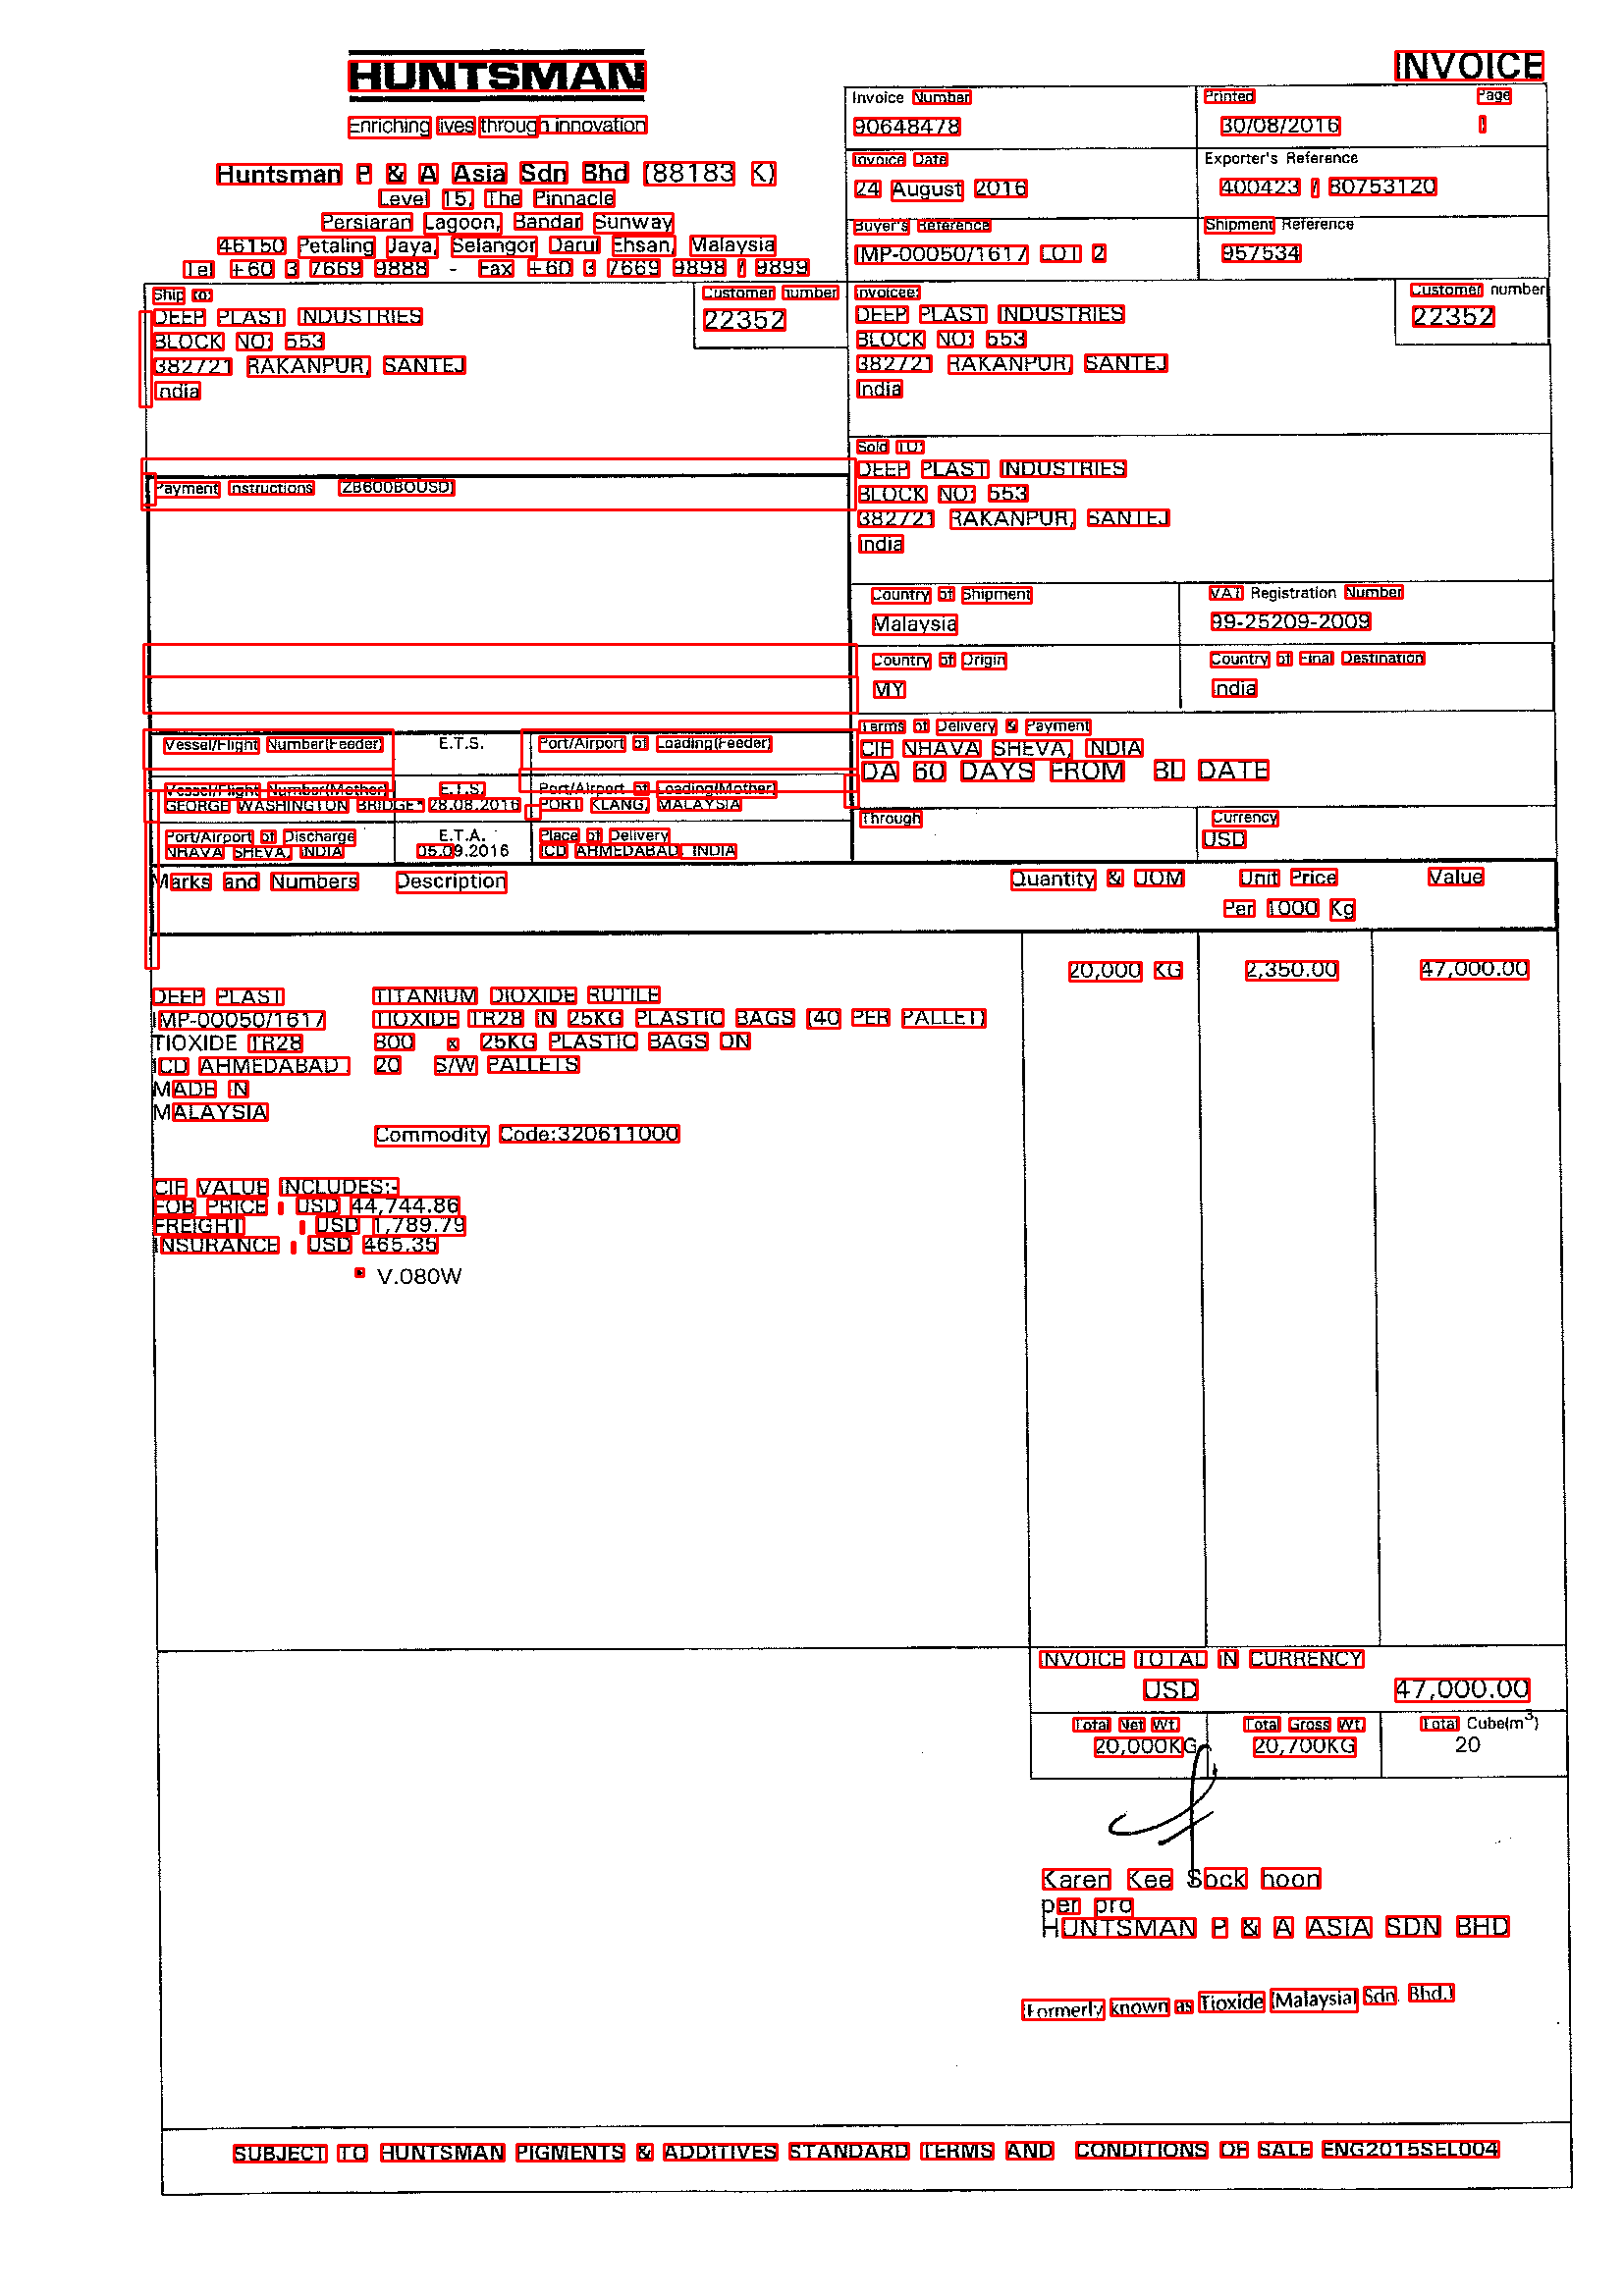

In [41]:
def plot_img_bb(i):
    custom_config = r'-l eng --oem 3 --psm 1'
    img = cv2.imread(invoices_images.values[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray[:gray.shape[0], :]
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    d = pytesseract.image_to_data(thresh, config=custom_config, output_type=Output.DICT)
    data = pd.DataFrame(d)
    data = data[(data.conf!=-1) & (data.text != '') & (data.text != ' ')]
    thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    for index, row in data.iterrows():
        if row.conf > 30:
            x1, y1, h, w = row[['left', 'top', 'height','width']]
            thresh = cv2.rectangle(thresh, (x1, y1), (x1+w, y1+h), (0,0,255), 2)                

    cv2_imshow(thresh)

plot_img_bb(7)

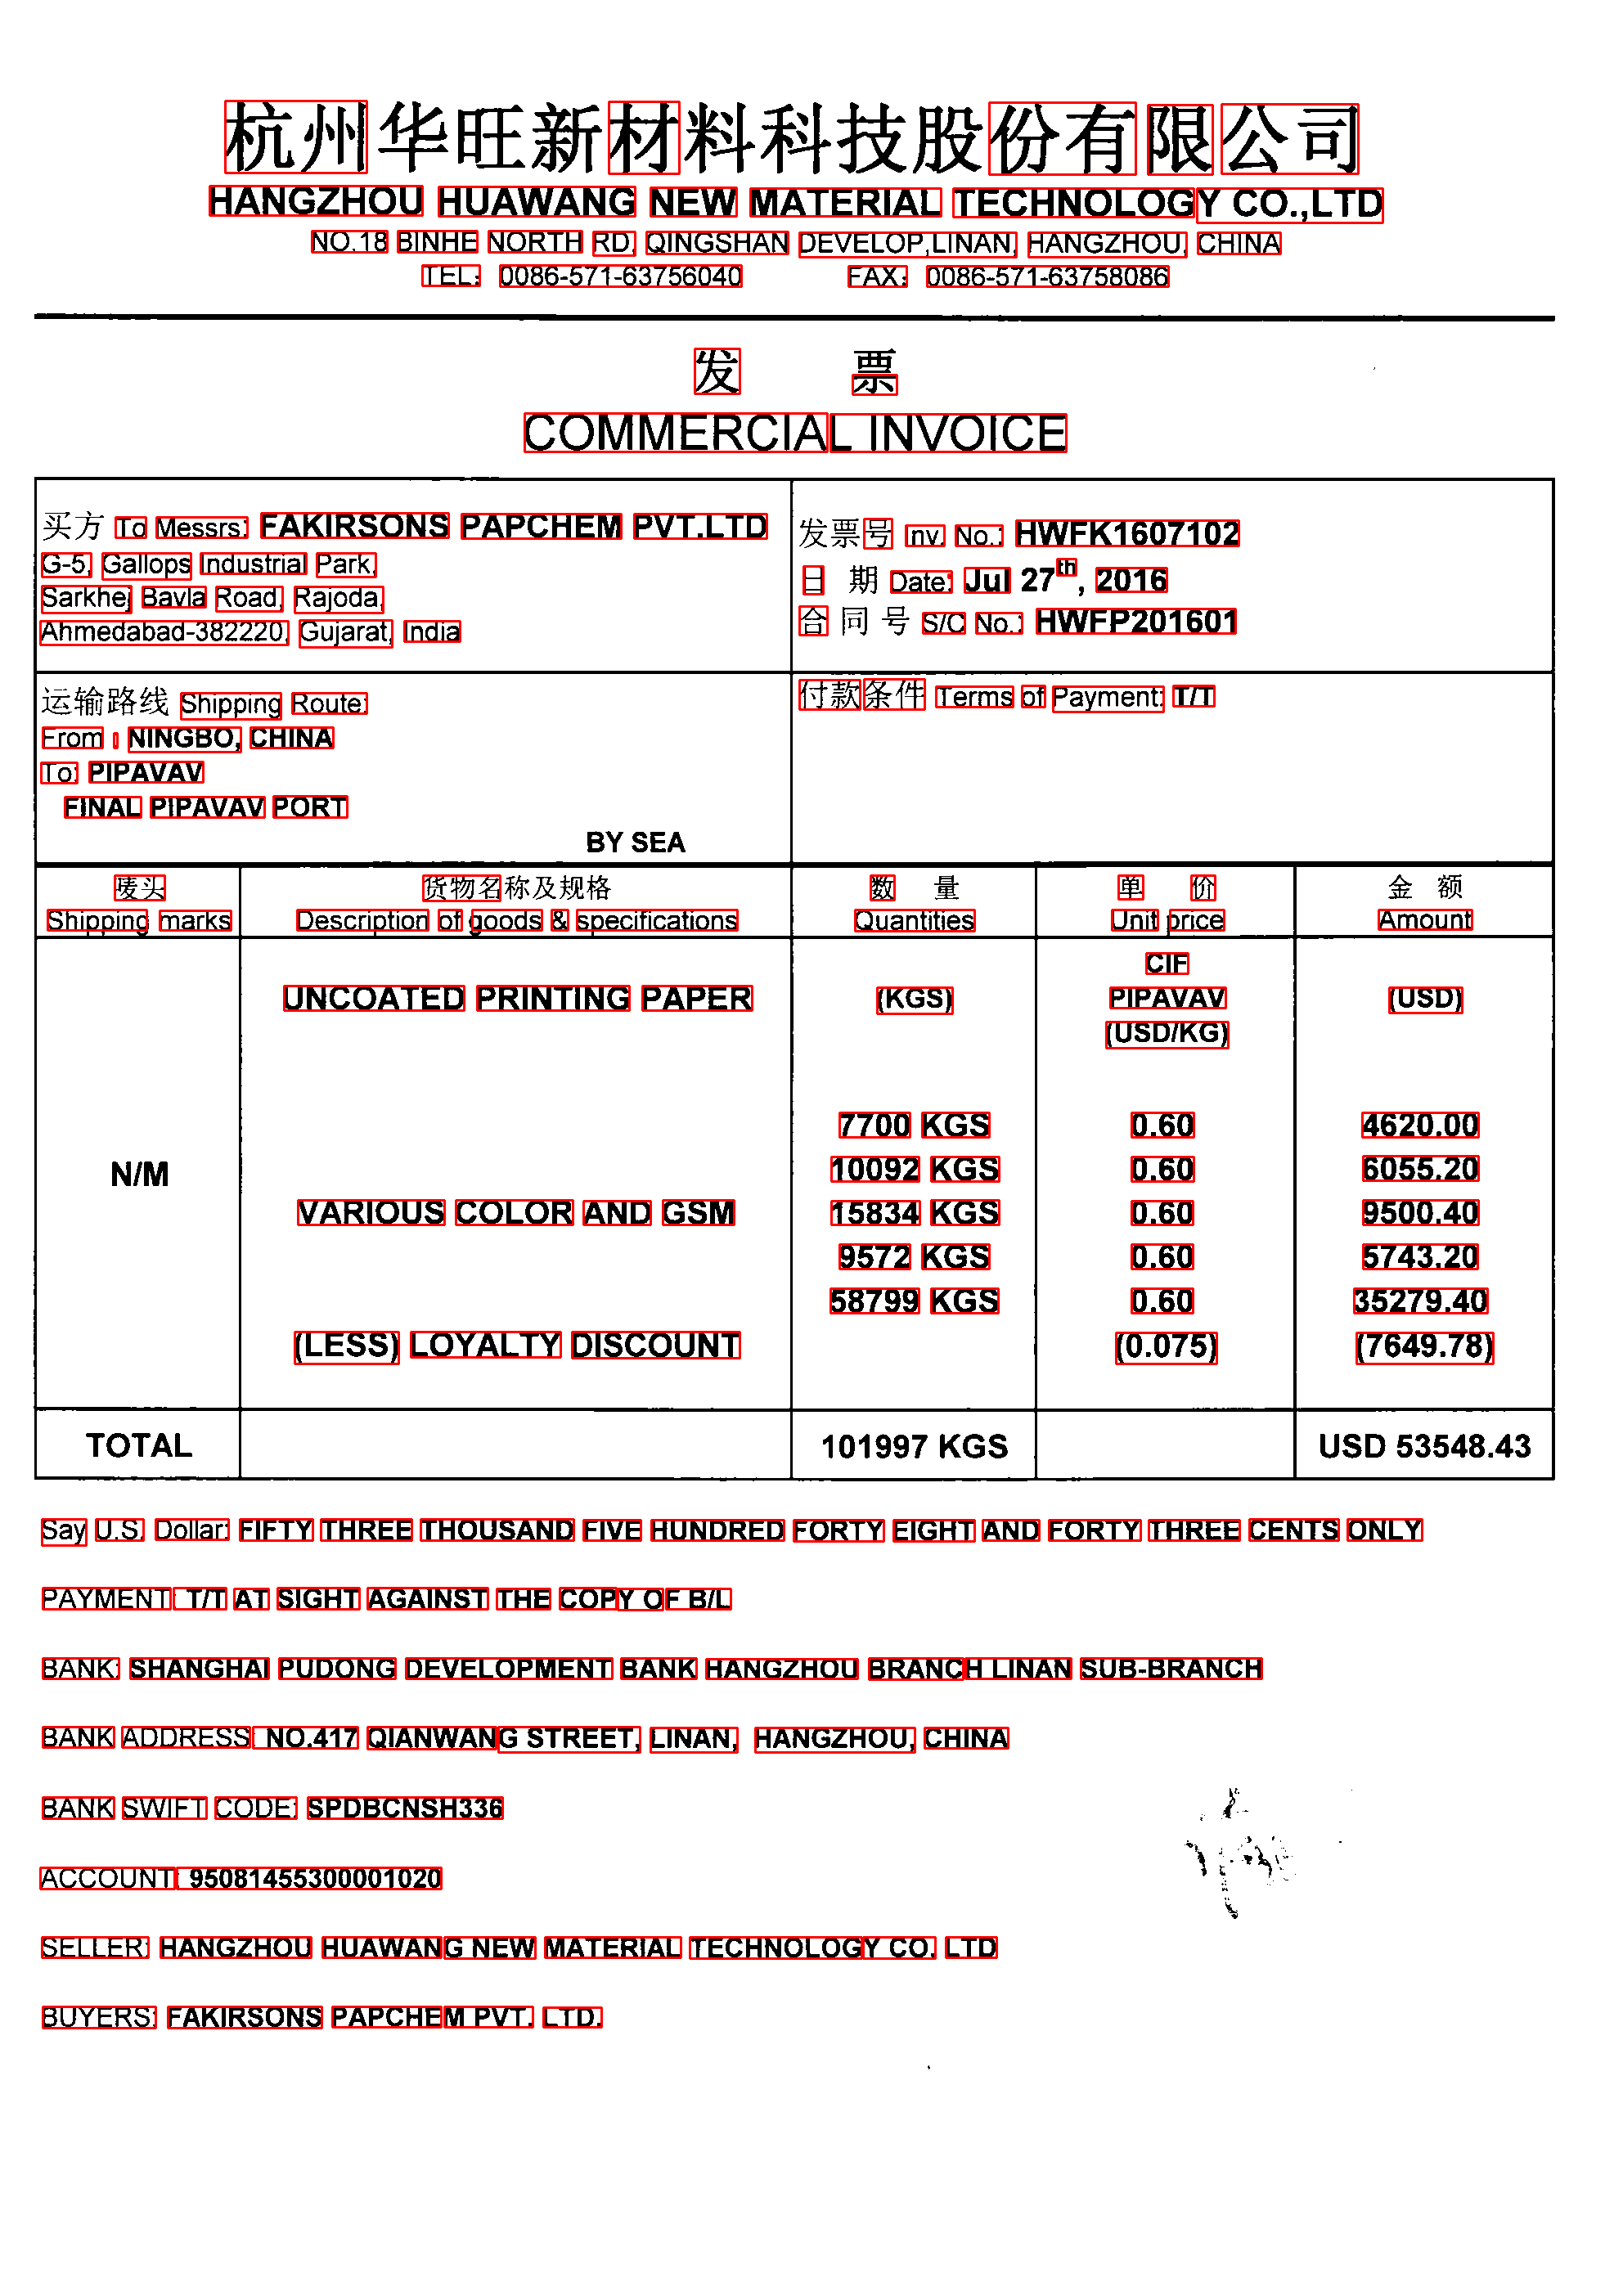

In [42]:
plot_img_bb(5)